In [3]:
import os
from netCDF4 import Dataset
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import datetime

In [5]:
dataframes = []

def calc_nino(SST_data):
    
    # Open netcdf file
    ds = xr.open_dataset(SST_data, decode_times=False)

    # Fix Dates to Match File
    reference_date = pd.to_datetime("1850-01-01")
    start_date = reference_date + datetime.timedelta(days = float(ds.time[0]))
    ds['time'] = pd.date_range(start=start_date, periods=ds.sizes['time'], freq='MS')

    # Select Niño 3.4 region (5N-5S, 170W-120W)
    ds_nino34 = ds.sel(lat=slice(-5, 5), lon=slice(190, 240))

    # Calculate area-weighted mean SST
    weights = np.cos(np.deg2rad(ds_nino34.lat))
    weights.name = 'weights'
    ds_weighted = ds_nino34['SST'].weighted(weights)
    mean_sst = ds_weighted.mean(dim=['lat', 'lon'])
    ds_nino34 = mean_sst

    # Select Jul-Oct
    month_list = [True if month in [7,8,9,10] else False for month in ds['time.month']]
    ds_nino34 = ds_nino34.loc[{'time' : month_list}] 

    # Remove 2014
    mask = ds_nino34['time'].dt.year != 2014
    ds_nino34 = ds_nino34.sel(time=mask)

    # Calculate temporal mean
    ds_nino34 = ds_nino34.groupby('time.year').mean()

    dataframes.append(pd.DataFrame({'year': np.array(ds_nino34.coords['year']), 'Average_SST': np.array(ds_nino34), 'Sim': [ds.attrs['case'][-8:]]*len(ds_nino34)}))
   # SST_Nino_Averages.append(nino34)

directory_path = "/Users/michaelvaden/Downloads/SST_Files/"

# add logic to sort files first by sim and year
file_list = sorted([filename for filename in os.listdir(directory_path) if filename.endswith(".nc")])

# Iterate through each file in the directory
for filename in file_list:
    file_path = os.path.join(directory_path, filename)
    calc_nino(file_path)

In [6]:
nino_data = pd.concat(dataframes)
nino_data.groupby(['Sim', 'year']).sum()

Average_SST
Sim      year             
1001.001 1940   300.755161
         1941   300.476758
         1942   302.393693
         1943   298.560676
         1944   300.111834
...                    ...
1301.020 2009   300.870808
         2010   301.778526
         2011   298.295271
         2012   299.273569
         2013   300.534646

[7400 rows x 1 columns]

In [50]:
#nino_data.to_csv('/Users/michaelvaden/Downloads/Nino_Data.csv', index=False)

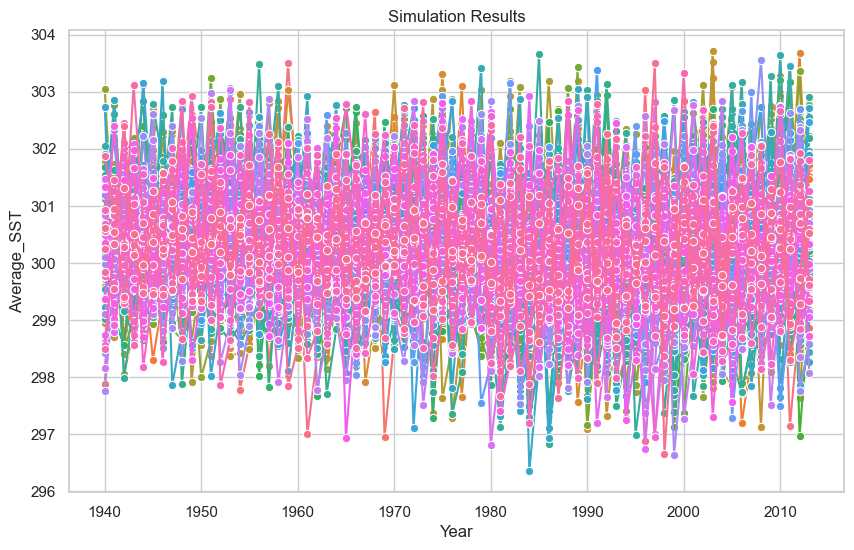

In [7]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='Average_SST', hue='Sim', data=nino_data, marker='o')

# Set plot labels and title
plt.xlabel('Year')
plt.ylabel('Average_SST')
plt.title('Simulation Results')
plt.legend([],[], frameon=False)

plt.show()

### Checks

/var/folders/s6/ny1859490sj527r3gf8tnfrh0000gn/T/ipykernel_51681/281323903.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.lineplot(x='year', y='Average_SST', data=nino_data.groupby(['year']).mean(), marker='o')


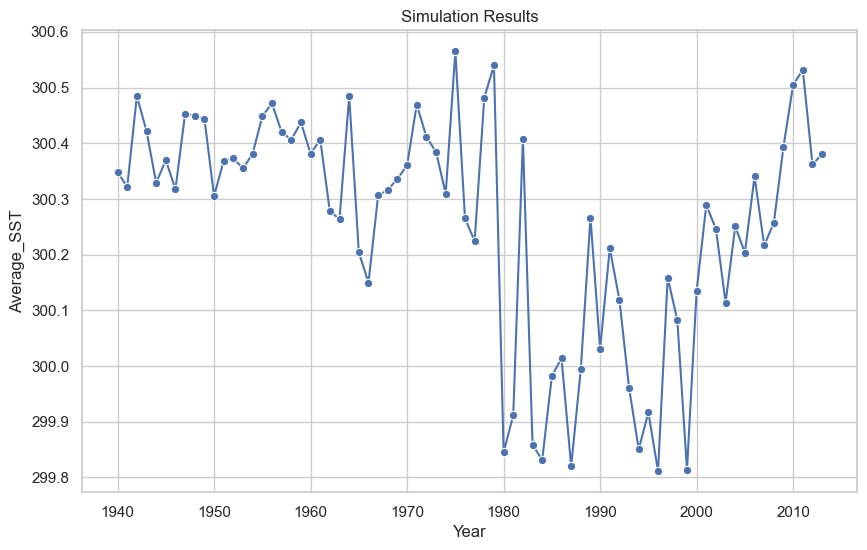

In [8]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='Average_SST', data=nino_data.groupby(['year']).mean(), marker='o')

# Set plot labels and title
plt.xlabel('Year')
plt.ylabel('Average_SST')
plt.title('Simulation Results')
plt.legend([],[], frameon=False)

plt.show()

In [9]:
nino_data['Sim'].value_counts()

1001.001    74
1231.014    74
1251.014    74
1251.013    74
1251.012    74
            ..
1281.001    74
1251.010    74
1251.009    74
1251.008    74
1301.020    74
Name: Sim, Length: 100, dtype: int64

In [11]:
nino_decade = nino_data.copy()

nino_decade['decade'] = nino_decade['year']//10*10  # or df['year'].round(-1)
nino_decade

,year,Average_SST,Sim,decade
0,1940,300.755161,1001.001,1940
1,1941,300.476758,1001.001,1940
2,1942,302.393693,1001.001,1940
3,1943,298.560676,1001.001,1940
4,1944,300.111834,1001.001,1940
...,...,...,...,...
9,2009,300.870808,1301.020,2000
0,2010,301.778526,1301.020,2010
1,2011,298.295271,1301.020,2010
2,2012,299.273569,1301.020,2010


In [12]:
nino_decade['warming_per_decade'] = nino_decade['Average_SST'].diff() / 10

nino_decade.groupby(['Sim', 'decade']).mean().reset_index()

,Sim,decade,year,Average_SST,warming_per_decade
0,1001.001,1940,1944.5,300.711639,0.024149
1,1001.001,1950,1954.5,300.620168,0.005713
2,1001.001,1960,1964.5,300.003647,-0.021419
3,1001.001,1970,1974.5,300.153736,-0.014163
4,1001.001,1980,1984.5,299.970613,-0.003274
...,...,...,...,...,...
795,1301.020,1970,1974.5,300.287854,-0.005403
796,1301.020,1980,1984.5,300.113404,-0.002513
797,1301.020,1990,1994.5,300.093390,-0.006850
798,1301.020,2000,2004.5,300.709694,0.016752


### Sanity Plot Correlation Map

In [71]:
SST_data = xr.open_dataset('/Users/michaelvaden/Downloads/SST_Data.nc', decode_times=True)

SST_data['SST']

<xarray.DataArray 'SST' (time: 7400, lat: 192, lon: 288)>
[409190400 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) datetime64[ns] 1940-01-01 1941-01-01 ... 2013-01-01
Attributes:
    units:         K
    long_name:     sea surface temperature
    cell_methods:  time: mean

In [89]:
Sim1_SST = nino_data.query("Sim == '1001.001'")['Average_SST']
Sim1_SST

0    300.755161
1    300.476758
2    302.393693
3    298.560676
4    300.111834
        ...    
9    300.281795
0    300.003020
1    300.044857
2    299.971079
3    302.825350
Name: Average_SST, Length: 74, dtype: float64

In [68]:
first_sim = SST_data['SST'][0:74]

first_sim

<xarray.DataArray 'SST' (time: 74, lat: 192, lon: 288)>
[4091904 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) datetime64[ns] 1940-01-01 1941-01-01 ... 2013-01-01
Attributes:
    units:         K
    long_name:     sea surface temperature
    cell_methods:  time: mean

In [101]:
first_sim.shape

(74, 192, 288)

In [99]:
corr_matrix= np.empty((192, 288))

for i in range(first_sim.shape[1]):
    for j in range(first_sim.shape[2]):
        sst_series = first_sim[:, i, j]
        
        corr_matrix[i, j] =  np.corrcoef(sst_series, Sim1_SST)[0, 1]

/Users/michaelvaden/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/michaelvaden/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [115]:
m = pd.DataFrame(corr_matrix)
m.index = SST_data['lat'][:]
m.columns = SST_data['lon'][:]
m

,0.00,1.25,2.50,3.75,5.00,6.25,7.50,8.75,10.00,11.25,...,347.50,348.75,350.00,351.25,352.50,353.75,355.00,356.25,357.50,358.75
-90.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-89.057592,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-88.115183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-87.172775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-86.230366,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86.230366,0.004207,0.002503,0.000595,-0.001264,-0.002787,-0.004426,-0.006044,-0.007495,-0.008488,-0.008509,...,0.036944,0.034080,0.031214,0.028131,0.024823,0.021322,0.017433,0.013049,0.008692,0.006254
87.172775,0.042802,0.041127,0.039626,0.038324,0.036914,0.035767,0.034981,0.034520,0.033979,0.032692,...,0.061717,0.059917,0.058040,0.056181,0.054323,0.052094,0.050116,0.048214,0.046112,0.044309
88.115183,0.075009,0.073872,0.072805,0.071959,0.071219,0.070353,0.069609,0.069000,0.068542,0.068343,...,0.086499,0.085526,0.084432,0.083126,0.081956,0.080892,0.079729,0.078446,0.077312,0.076248
89.057592,0.086212,0.085912,0.085595,0.085137,0.084778,0.084413,0.084032,0.083708,0.083313,0.082989,...,0.089533,0.089074,0.088823,0.088534,0.088278,0.087952,0.087581,0.087208,0.086832,0.086522


Nino Latitude and Longitude: region (5N-5S, 170W-120W)

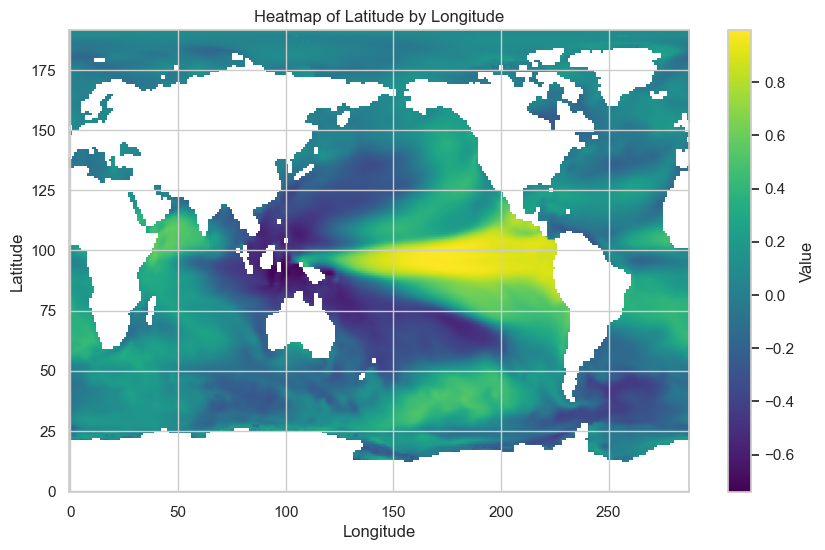

In [123]:
plt.figure(figsize=(10, 6))
plt.imshow(m, cmap='viridis', aspect = "auto", origin = "lower")  # Choose the appropriate colormap
plt.colorbar(label='Value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Heatmap of Latitude by Longitude')
plt.show()


### More Sanity plots of different simulations

In [173]:
def plot_corr_matrix(SST_sim, nino_sim, sim_number):
    corr_matrix= np.empty((192, 288))

    for i in range(SST_sim.shape[1]):
        for j in range(SST_sim.shape[2]):
            sst_series = SST_sim[:, i, j]
            
            corr_matrix[i, j] =  np.corrcoef(sst_series, nino_sim)[0, 1]

    m = pd.DataFrame(corr_matrix)
    m.index = SST_data['lat'][:]
    m.columns = SST_data['lon'][:]

    plt.figure(figsize=(10, 6))
    plt.imshow(m, cmap='viridis', aspect = "auto", origin = "lower")  # Choose the appropriate colormap
    plt.colorbar(label='Value')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Heatmap of Correlation for Simulation {sim_number}')
    plt.show()

/Users/michaelvaden/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/michaelvaden/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


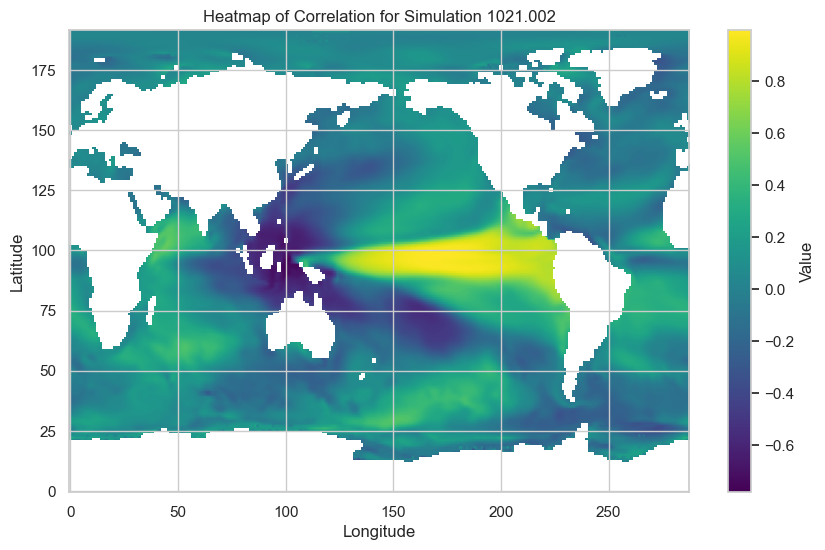

/Users/michaelvaden/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/michaelvaden/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


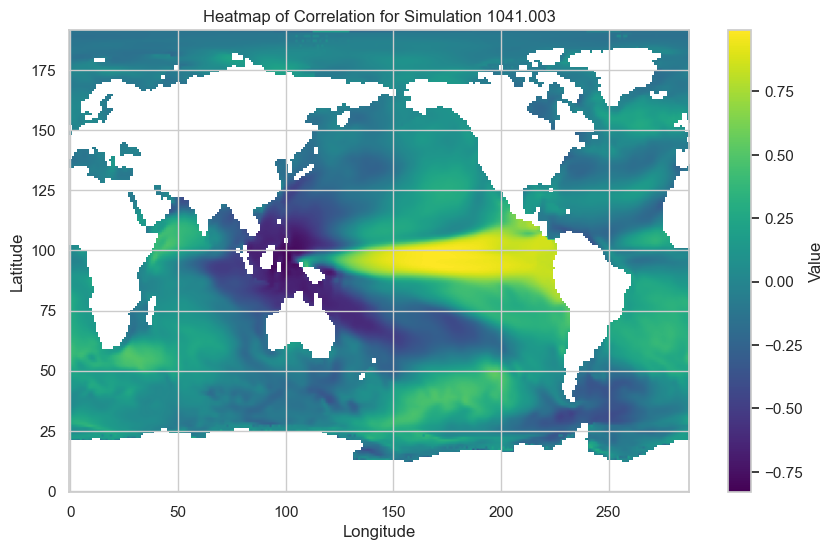

/Users/michaelvaden/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/michaelvaden/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


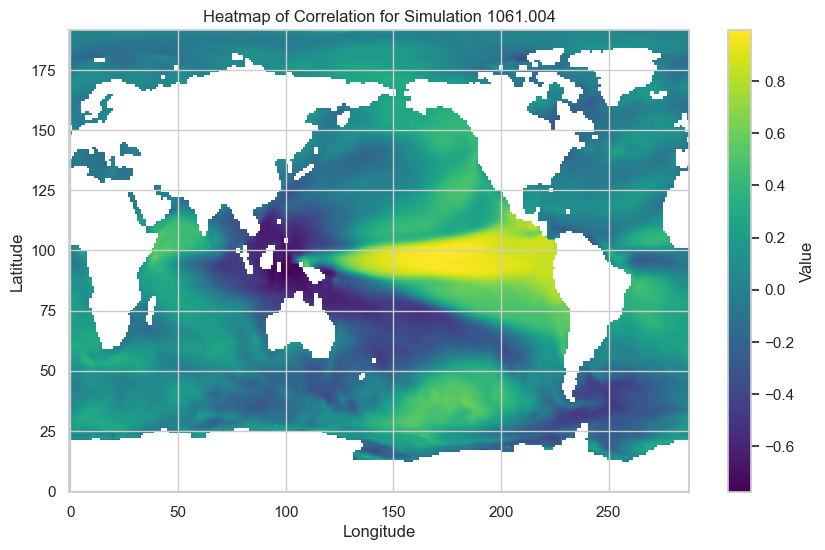

/Users/michaelvaden/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/michaelvaden/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


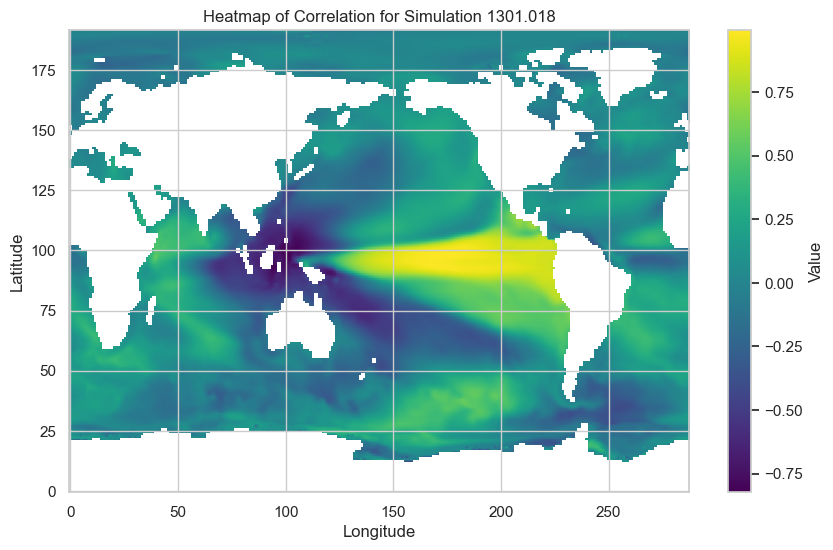

/Users/michaelvaden/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/michaelvaden/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


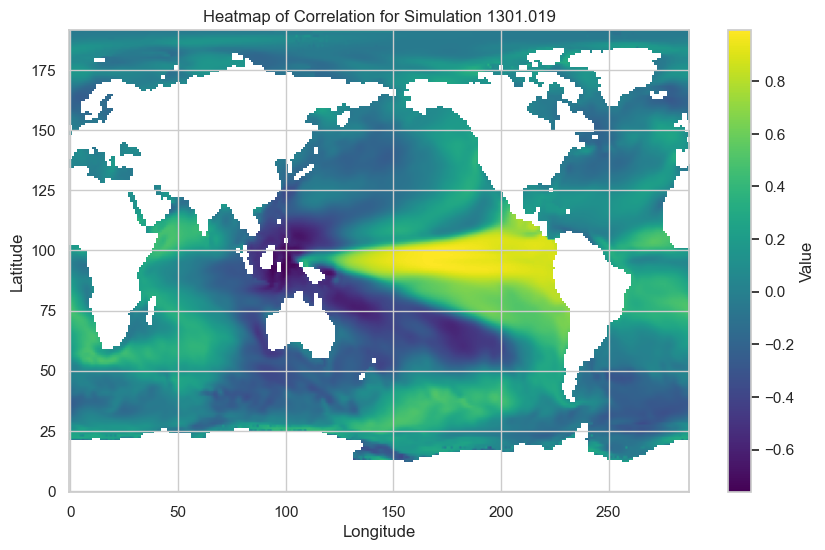

/Users/michaelvaden/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/michaelvaden/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


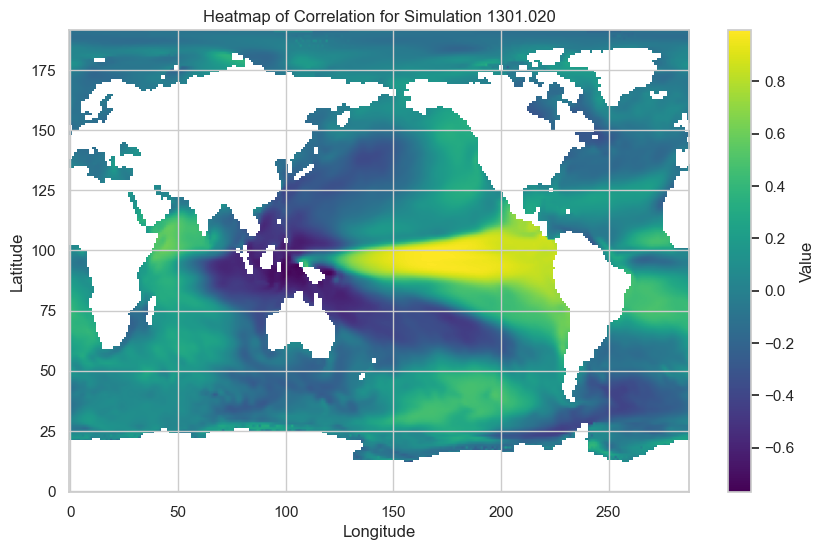

In [175]:
Sims = ['1021.002', '1041.003', '1061.004', '1301.018', '1301.019', '1301.020']

SST_range = [74, 148, 222, len(SST_data['SST'])-222, len(SST_data['SST'])-148, len(SST_data['SST'])-74]

for i in range(len(Sims)):
    simulation = Sims[i]
    nino_sim = nino_data.query("Sim == @simulation")['Average_SST']
    nth_sim = SST_data['SST'][SST_range[i]:SST_range[i]+74]

    plot_corr_matrix(nth_sim, nino_sim, simulation)

